
Polynomial Model Training RMSE: 1.910
Spline Model Training RMSE: 2.109

Spline Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Rings   No. Observations:                90615
Model:                            GLM   Df Residuals:                    90601
Model Family:                Gaussian   Df Model:                           13
Link Function:               Identity   Scale:                          4.4506
Method:                          IRLS   Log-Likelihood:            -1.9622e+05
Date:                Sun, 30 Mar 2025   Deviance:                   4.0323e+05
Time:                        21:55:16   Pearson chi2:                 4.03e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7183
Covariance Type:            nonrobust                                         
                                                       coef    std err          z      P>|z|      [0.025      0.97

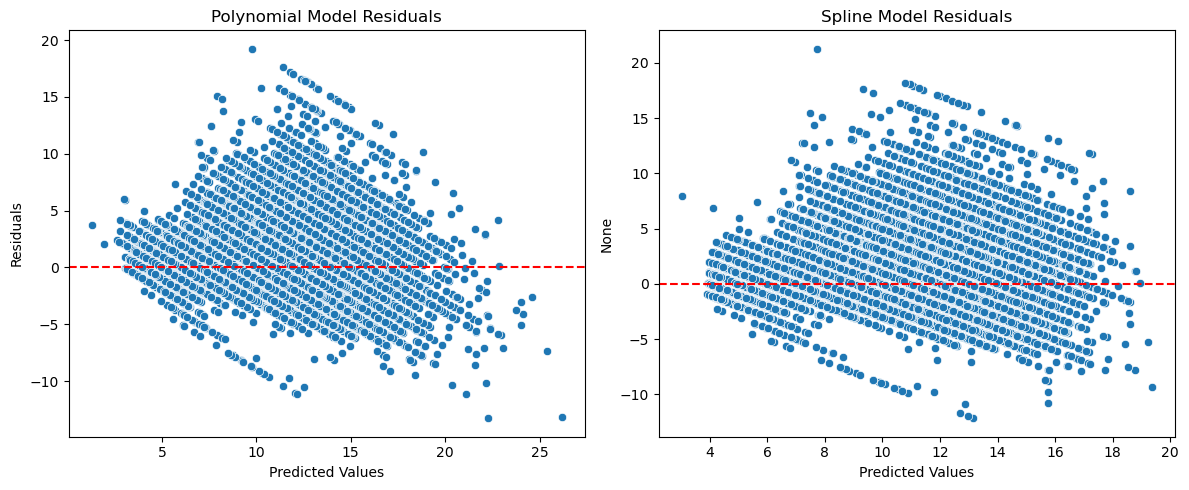

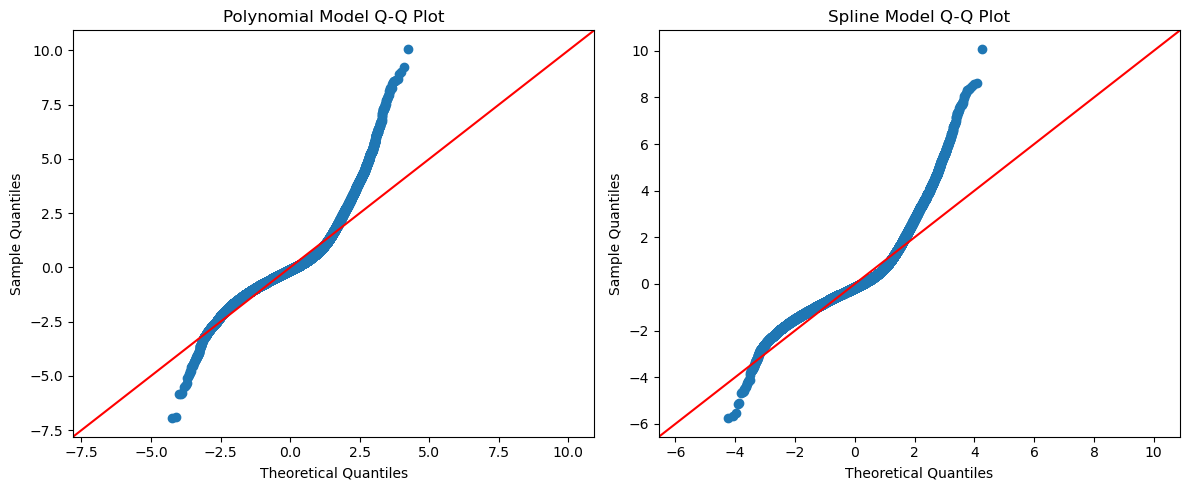

In [3]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from patsy import dmatrix
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import os


train = pd.read_csv('C:/Users/diana_o0n3rtm/OneDrive/Documents/NU/DDS-8555/Assignment 3/playground-series-s4e4/train.csv')
test = pd.read_csv('C:/Users/diana_o0n3rtm/OneDrive/Documents/NU/DDS-8555/Assignment 3/playground-series-s4e4/test.csv')

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Sex']),
        ('num', StandardScaler(), ['Length', 'Diameter', 'Height', 
         'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight'])
    ]
)

# Prepare data
X_train = train.drop(['id', 'Rings'], axis=1)
y_train = train['Rings']
X_test = test.drop('id', axis=1)

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names
feature_names = preprocessor.get_feature_names_out()

# =================================================================
#  Model 1: Polynomial Regression with Ridge Regularization
# =================================================================
# Create polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_poly = poly.fit_transform(X_train_processed)
X_test_poly = poly.transform(X_test_processed)

# Fit Ridge regression
poly_model = Ridge(alpha=0.5)
poly_model.fit(X_train_poly, y_train)

# Training performance
poly_pred_train = poly_model.predict(X_train_poly)
poly_rmse = np.sqrt(mean_squared_error(y_train, poly_pred_train))
print(f"\nPolynomial Model Training RMSE: {poly_rmse:.3f}")

# =================================================================
#  Model 2: Regression Splines
# =================================================================
# Prepare data for splines
train_spline = train.assign(
    Shell_weight=train['Shell weight'],
    Diameter=train['Diameter']
)
test_spline = test.assign(
    Shell_weight=test['Shell weight'],
    Diameter=test['Diameter']
)

# Create knots at quantiles
knots_shell = np.quantile(train['Shell weight'], [0.25, 0.5, 0.75])
knots_diameter = np.quantile(train['Diameter'], [0.33, 0.66])

# Fit GAM with splines
formula = "Rings ~ bs(Shell_weight, knots=knots_shell, degree=3) + bs(Diameter, knots=knots_diameter, degree=3) + Sex"
gam_spline = sm.GLM.from_formula(formula, data=train_spline, 
                                family=sm.families.Gaussian()).fit()

# Training performance
spline_pred_train = gam_spline.predict(train_spline)
spline_rmse = np.sqrt(mean_squared_error(y_train, spline_pred_train))
print(f"Spline Model Training RMSE: {spline_rmse:.3f}")

# Print spline model summary
print("\nSpline Model Summary:")
print(gam_spline.summary())

# =================================================================
#  Generate Predictions and Submissions
# =================================================================
# Polynomial model predictions
poly_pred = poly_model.predict(X_test_poly)
pd.DataFrame({'id': test.id, 'Rings': poly_pred}).to_csv('poly_submissionLIMM4.csv', index=False)

# Spline model predictions
spline_pred = gam_spline.predict(test_spline)
pd.DataFrame({'id': test.id, 'Rings': spline_pred}).to_csv('spline_submissionLIMM4.csv', index=False)

print("\nSubmission files created: poly_submissionLIMM4.csv, spline_submissionLIMM4.csv")

# =================================================================
# Diagnostic Plots
# =================================================================
# Residual plots
plt.figure(figsize=(12, 5))

# Polynomial residuals
plt.subplot(1, 2, 1)
sns.scatterplot(x=poly_pred_train, y=y_train - poly_pred_train)
plt.axhline(0, color='red', linestyle='--')
plt.title('Polynomial Model Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Spline residuals
plt.subplot(1, 2, 2)
sns.scatterplot(x=spline_pred_train, y=y_train - spline_pred_train)
plt.axhline(0, color='red', linestyle='--')
plt.title('Spline Model Residuals')
plt.xlabel('Predicted Values')

plt.tight_layout()
plt.show()

# Q-Q plots
plt.figure(figsize=(12, 5))

# Polynomial Q-Q
plt.subplot(1, 2, 1)
sm.qqplot(y_train - poly_pred_train, line='45', fit=True, ax=plt.gca())
plt.title('Polynomial Model Q-Q Plot')

# Spline Q-Q
plt.subplot(1, 2, 2)
sm.qqplot(y_train - spline_pred_train, line='45', fit=True, ax=plt.gca())
plt.title('Spline Model Q-Q Plot')

plt.tight_layout()
plt.show()